In [8]:
from Bio.PDB import *
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import freesasa
import numpy as np
import matplotlib.pyplot as plt
import math

import sys
import argparse
import warnings

In [4]:
def parse_PDB(filepath):
    pdb_parser = PDBParser()

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', PDBConstructionWarning)
        structure = pdb_parser.get_structure('protein', filepath)

    name = structure.header['name']
    head = structure.header['head']
    filter_words_name = ['pilus', 'pili', 'Pilus', 'Pili', 'PILUS', 'PILI', 'virus', 'Virus', 'VIRUS']
    filter_words_head = ['dna', 'DNA', 'rna', 'RNA']

    if any(word in name for word in filter_words_name) or any(word in head for word in filter_words_head):
        print('Given structure is either a Pilus or Virus protein or contains nucleotides.')
        print('Will not be analysed.')
        return None

    models = [model for model in structure]
    if len(models) > 1:
        model_number = input(str(len(models))+" models found. Please enter model id (1-index): ")
        model = models[int(model_number)-1]
    else:
        model = models[0]
    return model

In [58]:
def position_model(model):
    max_x = -100000
    max_y = -100000
    max_z = -100000
    min_x = 100000
    min_y = 100000
    min_z = 100000
    
    for chain in model:
        for residue in chain:
            for atom in residue:
                coordinates = atom.coord
                if coordinates[0] > max_x: max_x = coordinates[0]
                if coordinates[1] > max_y: max_y = coordinates[1]
                if coordinates[2] > max_z: max_z = coordinates[2]
                if coordinates[0] < min_x: min_x = coordinates[0]
                if coordinates[1] < min_y: min_y = coordinates[1]
                if coordinates[2] < min_z: min_z = coordinates[2]
    
    model.transform(rot=rotaxis2m(theta=0, vector=Vector(1,0,0)), 
                    tran=-0.5*np.array([max_x + min_x, max_y + min_y, max_z + min_z]))
    return model

In [46]:
def get_rotation(vector):
    """
    Rotates a PDB model so that a given vector will align with [0,0,1].
    returns rot_axis, angle in rad
    """
    vector2 = np.array(vector)
    rotation_axis = np.cross(np.array([0,0,1]), vector2)
    angle = math.asin(  np.linalg.norm(rotation_axis) / np.linalg.norm(vector2) )
    return rotation_axis, angle
    
get_rotation([1,0,0])    

(array([0, 1, 0]), 1.5707963267948966)

In [78]:
def get_z_bounds(model):
    max_z = -100000
    min_z = 100000
    for chain in model:
        for residue in chain:
            for atom in residue:
                coordinates = atom.coord
                if coordinates[2] > max_z: max_z = coordinates[2]
                if coordinates[2] < min_z: min_z = coordinates[2]
    return int(np.floor(min_z)), int(np.ceil(max_z))

In [168]:
def calculate_Q(model, vector):
    model_copy = model
    
    # Rotate model so that it aligns with [0,0,1]
    rot_axis, angle = get_rotation(vector)
    print(model_copy['A'][315]['CA'].coord)
    model_copy.transform(rot=rotaxis2m(theta=angle, vector=Vector(rot_axis)), tran=0)
    print(model_copy['A'][315]['CA'].coord)
    
    z_min, z_max = get_z_bounds(model_copy)
    print(z_min, z_max)
    
    # generate slices
    slices = make_slices(model_copy, z_min, z_max)
    print(len(slices))
    
    
    atom_radii = {'C':1.80, 'N':1.60, 'O':1.40, 'S':1.85}
    hydrophobic = ['PHE', 'GLY', 'ILE', 'LEU', 'MET', 'VAL', 'TRP', 'TYR']
    hydrophilic = ['ALA', 'CYS', 'ASP', 'GLU', 'ASN', 'GLN', 'HIS', 'LYS', 'PRO', 'ARG', 'SER', 'THR']
    atom_info = {'atom_radii': atom_radii, 'hydrophobic': hydrophobic, 'hydrophilic':hydrophilic}
    
    
    residue_dict = make_residue_dictionary(model)
    
    slice_scores = []
    
    for slice_height in slices.keys():
        slice_list = slices[slice_height]
        
        
        hydrophobic_factor = calc_hydrophobic_factor(slice_list, slice_height, atom_info)
        structure_factor = calc_structure_factor(slice_list, residue_dict, np.array(vector))
        #print("Slice: %s\tAtoms: %s\tHydro_factor: %1.3f\tStruc_factor: %1.3f"%
        #      (slice_height, len(slice_list), hydrophobic_factor, structure_factor))
        slice_scores.append(hydrophobic_factor * structure_factor)
    return slice_scores, z_min, z_max
    

model = parse_PDB('./structures/pdb1u9j.pdb')
model = position_model(model)

slice_scores, z_min, z_max = calculate_Q(model, [0,0,1])
    

[-11.17900467  -7.24599838  21.34600067]
[-11.17900467  -7.24599838  21.34600067]
-25 25
50


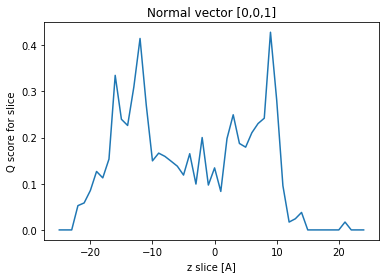

In [173]:
plt.figure()
plt.plot(range(z_min,z_max), slice_scores)
plt.title('Normal vector [0,0,1]')
plt.xlabel('z slice [A]')
plt.ylabel('Q score for slice');

In [104]:
def make_slices(model, z_min, z_max):
    slices = {}
    for i in range(z_min, z_max):
        slices[i] = []
    
    for chain in model:
        for residue in chain:
            for atom in residue:
                coordinates = atom.coord
                slices[int(np.floor(atom.coord[2]))].append(atom)
    
    return slices

In [145]:
def rectangle_grid(slice_list, z):
    """
    makes a rect around slice with height z
    """
    max_x = -1000
    min_x = 1000
    max_y = -1000
    min_y = 1000
    for atom in slice_list:
        coordinates = atom.coord
        if coordinates[0] > max_x: max_x = coordinates[0]
        if coordinates[0] < min_x: min_x = coordinates[0]
        if coordinates[1] > max_y: max_y = coordinates[1]
        if coordinates[1] < min_y: min_y = coordinates[1]
    
    points = []    
    offset = 1
    
    for x in np.linspace(min_x-offset, max_x+offset, max([int(len(slice_list)/3), 2])):
        points.append(np.array([x, min_y-offset, z]))
        points.append(np.array([x, max_y+offset, z]))
    for y in np.linspace(min_y-offset, max_y+offset, max([int(len(slice_list)/3), 2])):
        points.append(np.array([min_x-offset, y, z]))
        points.append(np.array([max_x+offset, y, z]))  
    
    return points

In [106]:
def get_outer_atoms(slice_list, rectangle_points):
    outer_atoms = set()
    outer_atom_ids = []
    
    for point in rectangle_points:
        current_dists = []
        for atom in slice_list:            
            current_dists.append(np.linalg.norm(point-atom.coord))
        
        outer_atoms.add(slice_list[np.argmin(current_dists)])
    
    for atom in list(outer_atoms):
        outer_atom_ids.append(atom.serial_number)
    
    
    return outer_atoms, outer_atom_ids

In [117]:
model = parse_PDB('./structures/pdb1u9j.pdb')
model = position_model(model)

z_min, z_max = get_z_bounds(model)
print(z_min, z_max)
    

slices = make_slices(model, z_min, z_max)


-25 25
3


[-30, 30, -30, 30]

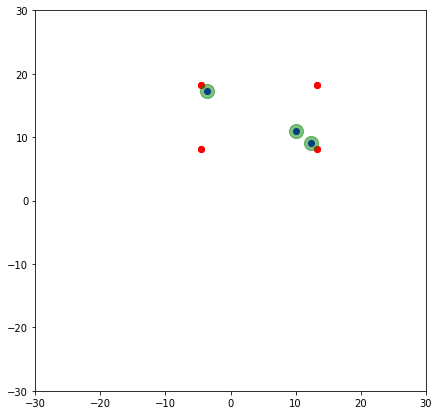

In [155]:
test_slice = -25

xs = []
ys = []
for atom in slices[test_slice]:
    xs.append(atom.coord[0])
    ys.append(atom.coord[1])
    

xs_rect = []
ys_rect = []
points = rectangle_grid(slices[test_slice], test_slice + 0.5)

for point in points:
    xs_rect.append(point[0])
    ys_rect.append(point[1])
    
    
xs_out = []
ys_out = []
outer_atoms, outer_atom_ids = get_outer_atoms(slices[test_slice], points)

for atom in list(outer_atoms):
    xs_out.append(atom.coord[0])
    ys_out.append(atom.coord[1])
    
    
plt.figure(figsize=(7,7))
plt.scatter(xs,ys, color="blue")
plt.scatter(xs_rect, ys_rect, color="red")
plt.scatter(xs_out, ys_out, color="green", s = 200, alpha=0.5)
plt.axis([-30,30,-30,30])

In [163]:
def get_unique_residues_from_slice(slice_list):
    ids = set()
    for atom in slice_list:
        if atom.parent.id[0] == ' ':
            ids.add((atom.parent.parent.id, atom.parent.id[1]))
    return list(ids)

In [166]:
def calc_structure_factor(slice_list, residue_dict, vector):
    residue_ids = get_unique_residues_from_slice(slice_list)
    
    straight_count = 0
    turn_count = 0
    endchain_count = 0
    
    
    for chain, resi in residue_ids:
        # Residue i-3
        try:
            prev_res = residue_dict[chain][resi-3].coord
        except KeyError:
            endchain_count += 1

        # Residue i
        curr_res = residue_dict[chain][resi].coord

        # Residue i+3
        try:
            next_res = residue_dict[chain][resi+3].coord
        except KeyError:
            endchain_count += 1

        prev_value = np.dot(vector, prev_res)
        curr_value = np.dot(vector, curr_res)
        next_value = np.dot(vector, next_res)

        if (prev_value < curr_value and curr_value < next_value) or (prev_value > curr_value and curr_value > next_value):
            straight_count += 1
        else:
            turn_count += 1
    
    straightness_factor = straight_count / len(residue_ids)
    turn_factor = 1 - (turn_count / len(residue_ids))
    endchain_factor = 1 - (endchain_count / len(residue_ids))    
    
    return straightness_factor * turn_factor * endchain_factor

In [161]:
def make_residue_dictionary(model):
    """
    Makes a dictionary of CA-Atoms from a model
    dict[chain][resi] = <CA-Atom>
    """
    residue_dict = {}
    
    for chain in model:
        residue_dict[chain.id] = {}
        for residue in chain:
            if residue.id[0] == ' ':
                residue_dict[chain.id][residue.id[1]] = residue['CA']
    return residue_dict

In [115]:
residue_dict['A'][319-3].coord
residue_dict['A'][319].coord
residue_dict['A'][319+3].coord

array([-6.7060051 , -7.71899796,  0.36499786])

In [139]:
straight_count = 0
turn_count = 0
endchain_count = 0

vector = np.array([0,0,1])

for chain, resi in residue_ids:
    try:
        prev_res = residue_dict[chain][resi-3].coord
    except KeyError:
        endchain_count += 1
        
    curr_res = residue_dict[chain][resi].coord
    
    try:
        next_res = residue_dict[chain][resi+3].coord
    except KeyError:
        endchain_count += 1
        
    prev_value = np.dot(vector, prev_res)
    curr_value = np.dot(vector, curr_res)
    next_value = np.dot(vector, next_res)
    
    if (prev_value < curr_value and curr_value < next_value) or (prev_value > curr_value and curr_value > next_value):
        straight_count += 1
    else:
        turn_count += 1

straightness_factor = straight_count / len(residue_ids)
turn_factor = 1 - (turn_count / len(residue_ids))
endchain_factor = 1 - (endchain_count / len(residue_ids))

structure_factor = straightness_factor * turn_factor * endchain_factor
print(structure_factor)

0.5216049382716049
